In [1]:
# !gdown --id '1eKNfEuNQadRW1H4NOoMw5sdnyHV14ze0'
# !unzip rtsd-r3.zip
# !rm -rf rtsd-r3.zip

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
import seaborn as sns
import pandas as pd
import os
import pathlib
import shutil
import cv2
import PIL

TEXT_COLOR = 'black'

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Merge gt_* and numbers_to_classes to single DataFrame

gt_test and gt_train now have IsPresentFlag, in next step we'll drop several types of signs

In [10]:
PROJECT_ROOT = pathlib.Path('rtsd-r3') #pathlib.Path(os.path.join(os.curdir, os.pardir))
ROOT_DIR = PROJECT_ROOT / 'data'
train_dir_source = ROOT_DIR / 'train'
train_dir = ROOT_DIR / 'train'

test_dir_source = ROOT_DIR / 'test'
test_dir = ROOT_DIR / 'test'

gt_train = pd.read_csv(ROOT_DIR / 'gt_train.csv')
gt_test = pd.read_csv(ROOT_DIR / 'gt_test.csv')
numbers_to_classes = pd.read_csv(ROOT_DIR / 'numbers_to_classes.csv')

gt_train = pd.merge(gt_train, numbers_to_classes, on='class_number', how='left', validate='many_to_one', copy=False)
gt_train.drop(['class_number'], inplace=True, axis=1)
gt_train['IsPresent'] = pd.Series([1 for x in range(len(gt_train.index))])

gt_test = pd.merge(gt_test, numbers_to_classes, on='class_number', how='left', validate='many_to_one', copy=False)
gt_test.drop(['class_number'], inplace=True, axis=1)
gt_test['IsPresent'] = pd.Series([1 for x in range(len(gt_test.index))])

del numbers_to_classes

In [11]:
test_sign_classes_set = set(gt_test['sign_class'].value_counts().index.tolist())
train_sign_classes_set = set(gt_train['sign_class'].value_counts().index.tolist())
print(test_sign_classes_set.symmetric_difference(train_sign_classes_set))
merged_test_train_classes_set = set.union(test_sign_classes_set,train_sign_classes_set)

{'1_19', '3_11_n5', '6_2_n20', '2_6', '5_22', '3_4_n8', '6_2_n60', '5_8', '5_11', '5_18'}


Эти классы есть в или в тесте или в трейне, но не в обоих.

,filename,sign_class,IsPresent
0,000000.png,2_1,1
1,000001.png,2_1,1
2,000002.png,2_1,1
3,000003.png,2_1,1
4,000004.png,1_23,1
...,...,...,...
70682,070682.png,1_23,1
70683,070683.png,1_23,1
70684,070684.png,1_23,1
70685,070685.png,1_23,1


{"5_19_1":19913,"2_1":8620,"5_16":3751,"5_15_2":3544,"3_27":2409,"1_23":2320,"5_20":1841,"3_24_n40":1804,"4_1_1":1673,"1_17":1145,"3_20":1036,"5_5":915,"5_15_1":873,"4_1_4":871,"3_1":868,"4_2_3":828,"1_25":802,"6_4":794,"7_3":790,"5_15_2_2":700,"3_24_n20":696,"4_2_1":693,"6_6":662,"5_15_3":619,"1_22":603,"2_3_2":593,"5_15_5":559,"2_5":512,"2_2":479,"3_4_1":476,"5_6":474,"4_2_2":433,"2_3_3":400,"4_1_2":359,"1_20_2":319,"7_5":312,"1_2":301,"1_11_1":298,"3_28":294,"5_14":251,"1_11":249,"1_16":235,"3_18":219,"1_1":198,"3_24_n50":193,"2_3":191,"3_18_2":169,"6_3_1":156,"5_15_7":152,"3_24_n5":149,"4_3":149,"5_7_2":141,"4_1_5":139,"4_1_2_1":135,"3_24_n30":131,"7_2":129,"1_12_2":128,"1_15":126,"3_13_r4.5":124,"1_8":120,"4_1_2_2":119,"5_7_1":119,"3_24_n80":111,"7_11":111,"3_2":110,"7_4":110,"7_7":101,"1_21":93,"5_3":91,"3_24_n60":87,"5_11":85,"7_12":84,"2_6":83,"1_33":82,"6_7":80,"3_24_n70":80,"1_12":79,"1_20_3":76,"1_5":72,"4_1_6":68,"6_2_n50":59,"3_32":54,"4_1_3":51,"5_21":51,"1_20":51,"7_6":5

,filename,sign_class,IsPresent
0,000000.png,5_19_1,1
1,000001.png,5_19_1,1
2,000002.png,5_19_1,1
3,000003.png,5_19_1,1
4,000004.png,5_19_1,1
...,...,...,...
22962,022962.png,5_15_5,1
22963,022963.png,5_15_5,1
22964,022964.png,5_15_5,1
22965,022965.png,5_15_5,1


{"5_19_1":4196,"2_1":2314,"5_16":1393,"5_15_2":1348,"3_27":1131,"5_15_3":973,"3_20":761,"5_15_2_2":688,"4_1_1":653,"5_15_5":649,"5_15_1":613,"4_2_1":486,"1_23":462,"2_3_2":404,"3_24_n40":377,"1_22":341,"4_2_3":333,"7_3":308,"4_1_4":295,"5_15_7":287,"6_4":280,"2_3":241,"1_8":233,"2_3_3":231,"1_25":214,"1_11_1":169,"5_20":166,"6_6":152,"3_24_n20":132,"1_11":131,"3_1":115,"4_1_2":114,"1_12":112,"4_2_2":110,"1_17":108,"1_16":106,"6_3_1":105,"5_5":94,"1_14":94,"1_15":90,"3_29":75,"3_24_n50":74,"3_24_n70":74,"3_4_1":73,"3_24_n5":73,"3_2":68,"1_13":64,"7_12":63,"2_2":63,"4_1_5":63,"1_20_2":61,"5_14":59,"5_6":58,"7_7":57,"3_18":52,"4_1_2_1":47,"1_12_2":47,"7_2":46,"3_28":45,"1_20":45,"1_27":45,"1_33":44,"6_2_n20":42,"5_7_1":39,"4_1_2_2":37,"3_19":34,"7_1":34,"7_4":34,"3_32":33,"3_13_r4.5":28,"7_11":27,"4_3":25,"3_24_n10":23,"2_5":23,"7_5":22,"3_18_2":21,"3_30":20,"7_6":18,"1_20_3":17,"3_24_n60":16,"6_7":16,"6_2_n50":15,"3_24_n30":15,"3_10":15,"5_7_2":14,"1_5":13,"3_24_n80":13,"1_1":10,"4_1_3":

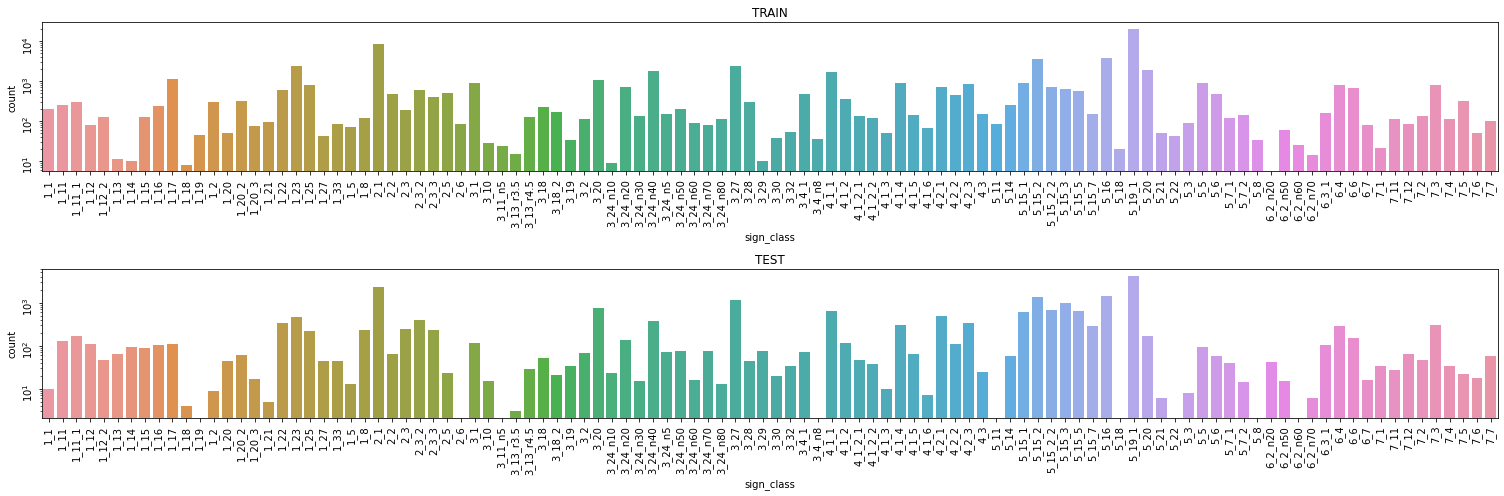

In [12]:
display(gt_train)
print(gt_train['sign_class'].value_counts().to_json())
display(gt_test)
print(gt_test['sign_class'].value_counts().to_json())

_, ax = plt.subplots(nrows=2, ncols=1, figsize=(21, 7))
ax[0].tick_params(labelrotation=90)
ax[1].tick_params(labelrotation=90)

g = sns.countplot(x='sign_class', data=gt_train, ax=ax[0], order=sorted(merged_test_train_classes_set));
g.set_yscale("log")
g = sns.countplot(x='sign_class', data=gt_test, ax=ax[1], order=sorted(merged_test_train_classes_set));
g.set_yscale("log")
# ax[1].set_ylim(ax[0].get_ylim()/)
ax[0].set_title('TRAIN')
ax[1].set_title('TEST')
plt.tight_layout()

Объеденим тест и трейн, т.к. их "мощности" (количество классов знаков) не равны.

In [13]:
merged_test_train = ROOT_DIR / 'ALL'
if (merged_test_train.exists()):
  shutil.rmtree(merged_test_train)

merged_test_train.mkdir(parents=True, exist_ok=True)

for filename in train_dir.iterdir():
  shutil.copy(filename, merged_test_train)

def incrementFile(filename_src, val=1):
    ext = str(filename_src).split('.')[-1]
    filename = str(filename_src).split('.')[-2]
    src_str_len = len(filename)
    filename_int = int(filename) + val
    filename = str(filename_int)
    
    while (len(filename) < src_str_len):
        filename = '0' + filename

    return filename + '.' + ext

last_filename = sorted(os.listdir(merged_test_train))[-1]
inc_val = int(last_filename.split('.')[-2]) + 1 # coz starts with 0


for filename in test_dir.iterdir():
  
  target_path = merged_test_train / incrementFile(filename.name, inc_val)
  print(filename, '->', target_path)
  shutil.copy(filename, target_path)

gt_test_copy = gt_test.copy()
for index, row in gt_test_copy.iterrows():
  # print(row)
  target_filename = incrementFile(row['filename'], inc_val)
  # print(row['filename'], '->', target_filename)

  gt_test_copy.loc[index, 'filename'] = incrementFile(row['filename'], inc_val)

gt = pd.concat([gt_train, gt_test_copy], ignore_index=True)
gt['Set'] = pd.Series([None for x in range(len(gt.index))])

del gt_test, gt_train, gt_test_copy

Streaming output truncated to the last 5000 lines.
rtsd-r3/data/test/020098.png -> rtsd-r3/data/ALL/090785.png
rtsd-r3/data/test/020252.png -> rtsd-r3/data/ALL/090939.png
rtsd-r3/data/test/005090.png -> rtsd-r3/data/ALL/075777.png
rtsd-r3/data/test/022187.png -> rtsd-r3/data/ALL/092874.png
rtsd-r3/data/test/015713.png -> rtsd-r3/data/ALL/086400.png
rtsd-r3/data/test/019030.png -> rtsd-r3/data/ALL/089717.png
rtsd-r3/data/test/018849.png -> rtsd-r3/data/ALL/089536.png
rtsd-r3/data/test/022498.png -> rtsd-r3/data/ALL/093185.png
rtsd-r3/data/test/012638.png -> rtsd-r3/data/ALL/083325.png
rtsd-r3/data/test/013841.png -> rtsd-r3/data/ALL/084528.png
rtsd-r3/data/test/000027.png -> rtsd-r3/data/ALL/070714.png
rtsd-r3/data/test/020294.png -> rtsd-r3/data/ALL/090981.png
rtsd-r3/data/test/022895.png -> rtsd-r3/data/ALL/093582.png
rtsd-r3/data/test/004961.png -> rtsd-r3/data/ALL/075648.png
rtsd-r3/data/test/021385.png -> rtsd-r3/data/ALL/092072.png
rtsd-r3/data/test/013808.png -> rtsd-r3/data/ALL/

In [20]:
gt.to_csv('gt.csv')

In [ ]:
!zip -r /content/merged.zip /content/rtsd-r3/data/ALL

In [ ]:
from google.colab import files
files.download("/content/merged.zip")

In [8]:
gt = pd.concat([gt_train, gt_test_copy])
gt['Set'] = pd.Series([None for x in range(len(gt.index))])

NameError: ignored

In [ ]:
gt_test_copy = gt_test.copy()
for index, row in gt_test_copy.iterrows():
  # print(row)
  target_filename = incrementFile(row['filename'], inc_val)
  print(row['filename'], '->', target_filename)

  gt_test_copy.loc[index, 'filename'] = incrementFile(row['filename'], inc_val)

In [ ]:
display(gt_test)
display(gt_train)
print(inc_val)

In [ ]:
!ls rtsd-r3/data/ALL